In [1]:
# Load the dataset

import pandas as pd
import numpy as np

data = pd.read_csv('/content/APA-DDoS-Dataset.csv')
data.head()

,ip.src,ip.dst,tcp.srcport,tcp.dstport,ip.proto,frame.len,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,...,tcp.seq,tcp.ack,frame.time,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,Label
0,192.168.1.1,192.168.23.2,2412,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071112000 Mountain Dayli...,8,432,4,216,4,216,DDoS-PSH-ACK
1,192.168.1.1,192.168.23.2,2413,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071138000 Mountain Dayli...,10,540,5,270,5,270,DDoS-PSH-ACK
2,192.168.1.1,192.168.23.2,2414,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071146000 Mountain Dayli...,12,648,6,324,6,324,DDoS-PSH-ACK
3,192.168.1.1,192.168.23.2,2415,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071152000 Mountain Dayli...,10,540,5,270,5,270,DDoS-PSH-ACK
4,192.168.1.1,192.168.23.2,2416,8000,6,54,0,0,1,1,...,1,1,16-Jun 2020 20:18:15.071159000 Mountain Dayli...,6,324,3,162,3,162,DDoS-PSH-ACK


In [4]:
import pandas as pd
import numpy as np

# Convert necessary columns to numeric
data['Bytes'] = pd.to_numeric(data['Bytes'], errors='coerce')
data['frame.len'] = pd.to_numeric(data['frame.len'], errors='coerce')
data['Packets'] = pd.to_numeric(data['Packets'], errors='coerce')
data['Tx Packets'] = pd.to_numeric(data['Tx Packets'], errors='coerce')
data['Tx Bytes'] = pd.to_numeric(data['Tx Bytes'], errors='coerce')
data['Rx Packets'] = pd.to_numeric(data['Rx Packets'], errors='coerce')
data['Rx Bytes'] = pd.to_numeric(data['Rx Bytes'], errors='coerce')

# Generate synthetic 'frame.time_relative' since the original 'frame.time' is a timestamp string
data['frame.time_relative'] = np.arange(len(data)) / 1000  # Assuming 1 ms interval for simplicity

# Add new features
data['traffic_rate'] = data['Bytes'] / data['frame.time_relative'].replace(0, np.nan)  # Avoid division by zero
data['tcp_flags_sum'] = data['tcp.flags.syn'] + data['tcp.flags.reset'] + data['tcp.flags.push'] + data['tcp.flags.ack']
data['packet_size_ratio'] = data['Tx Bytes'] / data['Rx Bytes'].replace(0, np.nan)  # Avoid division by zero
data['interaction_intensity'] = data['Packets'] / data['frame.time_relative'].replace(0, np.nan)  # Avoid division by zero
data['flow_entropy'] = -(data['Tx Packets'] * np.log(data['Tx Packets'].replace(0, np.nan)) +
                         data['Rx Packets'] * np.log(data['Rx Packets'].replace(0, np.nan)))  # Avoid log(0)

# Display the first few rows of the updated dataset
data.head()


,ip.src,ip.dst,tcp.srcport,tcp.dstport,ip.proto,frame.len,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,...,Tx Bytes,Rx Packets,Rx Bytes,Label,frame.time_relative,traffic_rate,tcp_flags_sum,packet_size_ratio,interaction_intensity,flow_entropy
0,192.168.1.1,192.168.23.2,2412,8000,6,54,0,0,1,1,...,216,4,216,DDoS-PSH-ACK,0.000,NaN,2,1.0,NaN,-11.090355
1,192.168.1.1,192.168.23.2,2413,8000,6,54,0,0,1,1,...,270,5,270,DDoS-PSH-ACK,0.001,540000.0,2,1.0,10000.000000,-16.094379
2,192.168.1.1,192.168.23.2,2414,8000,6,54,0,0,1,1,...,324,6,324,DDoS-PSH-ACK,0.002,324000.0,2,1.0,6000.000000,-21.501114
3,192.168.1.1,192.168.23.2,2415,8000,6,54,0,0,1,1,...,270,5,270,DDoS-PSH-ACK,0.003,180000.0,2,1.0,3333.333333,-16.094379
4,192.168.1.1,192.168.23.2,2416,8000,6,54,0,0,1,1,...,162,3,162,DDoS-PSH-ACK,0.004,81000.0,2,1.0,1500.000000,-6.591674


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Select numeric columns for PCA
X = data.select_dtypes(include=[np.number]).drop(columns=['frame.time_relative'])  # Removing time-based column
y = data['Label']  # Assuming 'Label' is the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle NaN values by replacing them with the column mean
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# Print explained variance
print("Explained Variance Ratio:", explained_variance)

Explained Variance Ratio: [0.98931825 0.01057724]


In [7]:
from sklearn.decomposition import PCA

# Apply PCA with only the first principal component
pca_1 = PCA(n_components=1)
X_train_pca_1 = pca_1.fit_transform(X_train)
X_test_pca_1 = pca_1.transform(X_test)

# Print the first few transformed values
print(X_train_pca_1[:5])  # Displaying first 5 rows for verification


[[  7218.71323682]
 [-14136.6035915 ]
 [ 13027.39531799]
 [ 27132.33706097]
 [-21651.71233301]]


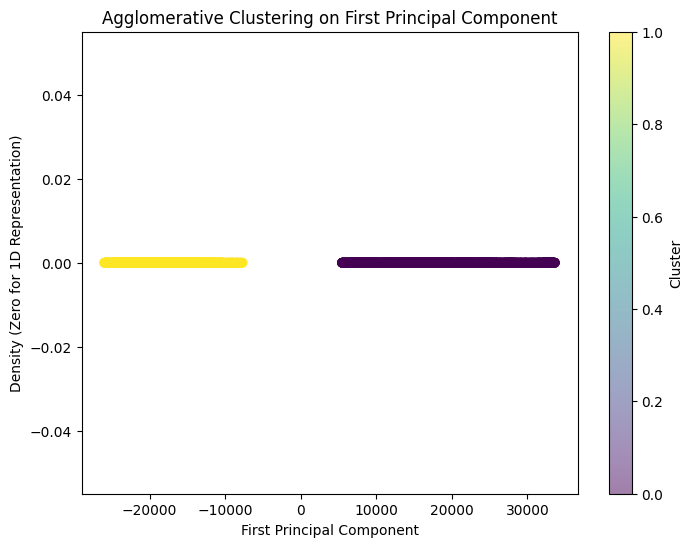

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Reduce dataset size for clustering to avoid memory issues
sample_size = 10000  # Adjust based on available memory
X_sample = X_train_pca_1[:sample_size]

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='average')  # 'average' uses less memory
clusters = agg_clustering.fit_predict(X_sample)

# Visualizing clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_sample[:, 0], np.zeros_like(X_sample[:, 0]), c=clusters, cmap='viridis', alpha=0.5)
plt.title("Agglomerative Clustering on First Principal Component")
plt.xlabel("First Principal Component")
plt.ylabel("Density (Zero for 1D Representation)")
plt.colorbar(label="Cluster")
plt.show()
